#### An Investigation of Option Parity Graphs.

When holding a single option, the payoff expected is straightforward. The hockey stick diagrams taught in various textbooks are an intuitive way to understand the outcomes. When holding multiple options, however, with different strikes or premiums, the position can quickly become opaque.

In this notebook, I look at some basic parity graphs and build up to the creation of a class which can easily display your current position and visualize the favourable outcomes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

In [5]:
#Plot payoff diagrams for a single call or Put option.

strike_price = 90 #Strike price of Option
final_prices = np.arange(np.max(strike_price-50,0), strike_price+50, 0.5) #asset price @ expiry
premium = 4 #Premium / Price of option

def call_payout(final_prices, strike_price, premium, quantity=1):
        return quantity * (np.where(final_prices > strike_price, final_prices - strike_price, 0) - premium) 
def put_payout(final_prices, strike_price, premium, quantity=1):
        return quantity * (np.where(final_prices < strike_price, strike_price - final_prices, 0) - premium)

def call_breakeven(strike_price, premium):
    return strike_price + premium
def put_breakeven(strike_price, premium):
    return strike_price - premium

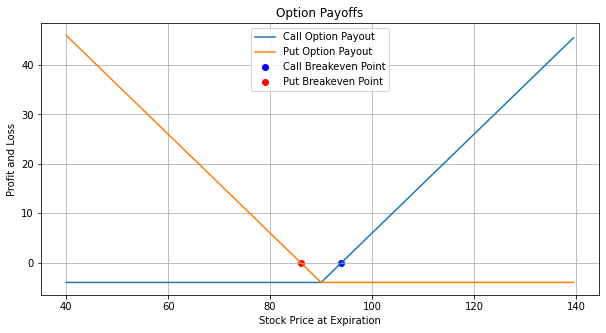

In [7]:
plt.figure(figsize=(10,5))
plt.title('Option Payoffs')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit and Loss')

call_payout_plot = call_payout(final_prices, strike_price, premium)
put_payout_plot = put_payout(final_prices, strike_price, premium)
breakeven_call_pt = call_breakeven(strike_price, premium)
breakeven_put_pt = put_breakeven(strike_price, premium)

plt.plot(final_prices, call_payout_plot, label='Call Option Payout')
plt.plot(final_prices, put_payout_plot, label='Put Option Payout')
plt.scatter(breakeven_call_pt, 0, color='b', label='Call Breakeven Point', marker='o')
plt.scatter(breakeven_put_pt, 0, color='r', label='Put Breakeven Point', marker='o')

plt.legend()
plt.grid(True)
plt.show()

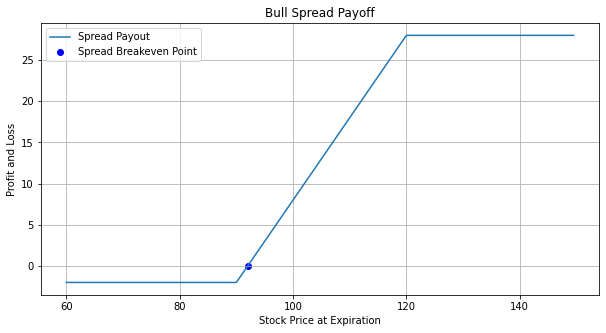

In [9]:
#Now try the same for some basic spread e.g. a Bull Spread 

#Bull Spread: Long one option, short another option with higher strike. Same expiration and same underlying

strike_1 = 90  # Lower strike price
premium_1 = 3  # Premium for the lower strike call option
strike_2 = 120  # Higher strike price
premium_2 = 1  # Premium for the higher strike call option
final_prices = np.arange(np.max(strike_1-(strike_2-strike_1),0), strike_2+(strike_2-strike_1), 0.5)

def bull_spread(final_prices, strike_1, strike_2, premium_1, premium_2):
    call1 = call_payout(final_prices, strike_1, premium_1)
    call2 = call_payout(final_prices, strike_2, premium_2)
    return call1 - call2

plt.figure(figsize=(10,5))
plt.title('Bull Spread Payoff')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit and Loss')

bullspread_payout_plot = bull_spread(final_prices, strike_1, strike_2, premium_1, premium_2)
plt.plot(final_prices, bullspread_payout_plot, label='Spread Payout')

#Think about how the spread impacts the breakeven point.
breakeven_bullspread_pt = call_breakeven(strike_1, premium_1 - premium_2) # only need to change the Premium variable.
plt.scatter(breakeven_bullspread_pt, 0, color='b', label='Spread Breakeven Point', marker='o')

plt.legend()
plt.grid(True)
plt.show()

In [11]:
#In general, once we have a position, we can easily add another option to the payoff diagram as follows:
#Writing an option: subtract the potential payouts across the range of final prices, add the premium across all final prices.
#Purchasing an option: add the potential payouts across the range of final prices, subtract the premium across all final prices.

#We can write a class object to manage the options in our position, and produce payout diagrams when required.

class OptionPosition:
    def __init__(self):
        self.options = []
        self.graph_max = 10
        self.final_prices = np.arange(0, 200, 0.5)
        self.payouts = np.zeros_like(self.final_prices)
    
    def update_graph_max(self, strike_price):
        if strike_price > self.graph_max - 50:
            self.graph_max = strike_price + 50
        
    def call_payout(final_prices, strike_price, premium, quantity=1):
        return quantity * (np.where(final_prices > strike_price, final_prices - strike_price, 0) - premium)
    
    def put_payout(final_prices, strike_price, premium, quantity=1):
        return quantity * (np.where(final_prices < strike_price, strike_price - final_prices, 0) - premium)

    def add_call_option(self, strike_price, premium, quantity=1):
        self.update_graph_max(strike_price)
        option = {
            'type': 'Call',
            'strike_price': strike_price,
            'premium': premium,
            'quantity': quantity
        }
        self.options.append(option)
        self.payouts = np.add(self.payouts, call_payout(self.final_prices, strike_price, premium, quantity=quantity))

    def add_put_option(self, strike_price, premium, quantity=1):
        self.update_graph_max(strike_price)
        option = {
            'type': 'Put',
            'strike_price': strike_price,
            'premium': premium,
            'quantity': quantity
        }
        self.options.append(option)
        self.payouts = np.add(self.payouts, put_payout(self.final_prices, strike_price, premium, quantity))


    def show_position(self):
        if len(self.options) == 0:
            print("Current position is closed.")
            return

        print("Current Position:")
        for index, option in enumerate(self.options, start=1):
            option_type = option['type']
            strike_price = option['strike_price']
            premium = option['premium']
            quantity = option['quantity']
            print(f"Option {index}: {option_type} - Strike Price: {strike_price}, Premium: {premium}, Quantity: {quantity}")
    
    def find_breakeven_points(self):
        
        # Use change of signs in payouts to find where the crossings are.
        crossings = np.where(np.diff(np.sign(self.payouts)))[0]
        
        # Filter out duplicate crossings, keeping only the first occurrence
        unique_crossings = []
        prev_index = -1
        for crossing in crossings:
            if crossing != prev_index + 1:
                unique_crossings.append(crossing)
            prev_index = crossing

        # Convert indices to integers
        unique_crossings = np.array(unique_crossings, dtype=int)
        return unique_crossings
    
    def parity_graph(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.final_prices, self.payouts, label='Position Payoff')
        plt.xlabel('Final Asset Prices')
        plt.ylabel('Payoff')
        plt.title('Combined Position Payoff')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        
        # Add and annotate breakeven points on the plot.
        breakeven_points = self.find_breakeven_points()
        for point in breakeven_points:
            plt.scatter(self.final_prices[point], self.payouts[point], color='green', s=50, label='Breakeven Point')
            plt.annotate(f'{self.final_prices[point]}', (self.final_prices[point], self.payouts[point]),
                         textcoords="offset points", xytext=(5, 5), ha='center')

        # Prevent duplicate labels appearing in the legend.
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        
        plt.xlim(0, self.graph_max)
        plt.grid(True)
        plt.show()

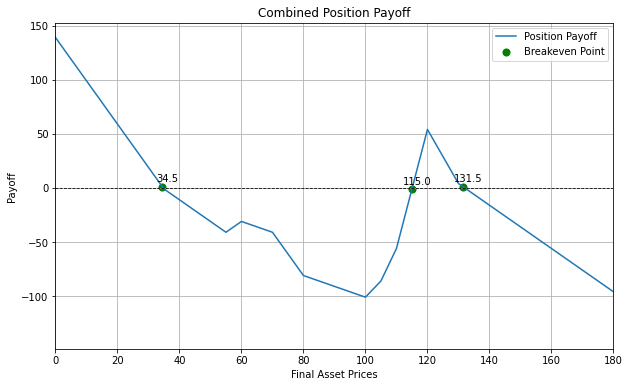

In [42]:
pos = OptionPosition()

pos.add_call_option(35, 58, quantity=2)
pos.add_call_option(55, 32, quantity=4)
pos.add_call_option(105, 2, quantity=3)
pos.add_call_option(110, 1, quantity=5)
pos.add_call_option(120, 1, quantity=-16)
pos.add_put_option(130, 60, quantity=3)
pos.add_put_option(100, 25, quantity=4)
pos.add_put_option(80, 8, quantity=3)
pos.add_put_option(70, 4, quantity=-3)
pos.add_put_option(60, 10, quantity=-3)


pos.parity_graph()

In [43]:
pos.show_position()

Current Position:
Option 1: Call - Strike Price: 35, Premium: 58, Quantity: 2
Option 2: Call - Strike Price: 55, Premium: 32, Quantity: 4
Option 3: Call - Strike Price: 105, Premium: 2, Quantity: 3
Option 4: Call - Strike Price: 110, Premium: 1, Quantity: 5
Option 5: Call - Strike Price: 120, Premium: 1, Quantity: -16
Option 6: Put - Strike Price: 130, Premium: 60, Quantity: 3
Option 7: Put - Strike Price: 100, Premium: 25, Quantity: 4
Option 8: Put - Strike Price: 80, Premium: 8, Quantity: 3
Option 9: Put - Strike Price: 70, Premium: 4, Quantity: -3
Option 10: Put - Strike Price: 60, Premium: 10, Quantity: -3
